In [1]:
import loader
data_user = loader.load('./data/userMini.json')

In [16]:
data_business = loader.load('./data/businessMini.json')

In [3]:
banned_category = ['Restaurants']


In [3]:
banned_category = []

In [4]:
def index_category_builder(business):
    index_category = {}
    index = 0
    for v in business.values():
        for category in v['categories']:
            if category not in index_category.keys() and category not in banned_category:
                index_category[category] = index
                index += 1
    return index_category
index_category = index_category_builder(data_business)


In [5]:
## get index_user and array_user
def index_user_builder(user, business):
    index_user = {}
    array_user = []
    index = 0
    for k, v in user.items():
        index_user[k] = index
        index += 1
        tmp = [0 for i in range(len(index_category))]
        for businessId in v:
            for category in business[businessId]['categories']:
                if category not in banned_category:
                    tmp[index_category[category]] += 1
        array_user.append(tmp)
    return index_user, array_user
index_user, array_user = index_user_builder(data_user, data_business)


In [6]:
del data_business, data_user

In [7]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
array_user = scaler.fit_transform(array_user)

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
array_user = scaler.fit_transform(array_user)

In [8]:
## 余弦相似度的距离
def get_cos_dis(array):
    from sklearn.metrics.pairwise import pairwise_distances
    dis = pairwise_distances(array,metric="cosine")
    return dis

## 绘制KMeans K的聚类效果变化图
def measure_k(clusters, distortions):
    import matplotlib.pyplot as plt
    plt.plot(clusters,distortions,marker="o")
    plt.xlabel("簇数量")
    plt.ylabel("簇内误方差(SSE)")
    plt.show()

In [9]:
dis = get_cos_dis(array_user)

In [10]:
loader.save_dis('./data/dis_cos_directUser.txt', dis)

In [11]:
del dis

In [12]:
from sklearn.cluster import KMeans

In [23]:
method = KMeans(n_clusters=2, random_state=9, algorithm='full')
kmeans_cluster = method.fit(array_user)

In [14]:
## 手肘法评测聚类效果
import matplotlib.pyplot as plt
distortions = []
for i in range(1,11):
    km = KMeans(n_clusters=i, random_state=9, algorithm='full')
    km.fit(array_user)
    #获取K-means算法的SSE
    distortions.append(km.inertia_)

<Figure size 640x480 with 1 Axes>

In [13]:
## 轮廓系数评测聚类效果
from sklearn import metrics
clusters = [2,3,4,5,8]
distortions = []
for i in clusters:
    km = KMeans(n_clusters=i, random_state=9, algorithm='full')
    km.fit(array_user)
    silhouette_score = metrics.silhouette_score(array_user, km.labels_, metric='euclidean')
    distortions.append(silhouette_score)
    

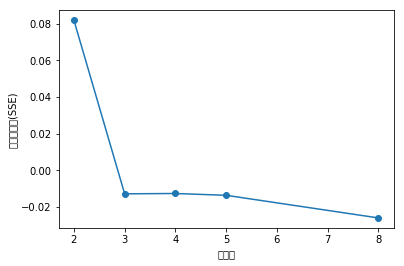

In [15]:
%matplotlib inline
measure_k(clusters, distortions)

In [11]:
from fastCluster.fastSearchCluster import FastSearchCluster
pre = FastSearchCluster()
pre.pre_data('dis_cos_directUser.txt')

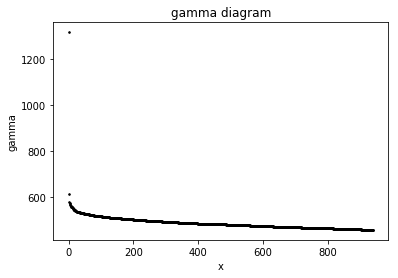

In [12]:
%matplotlib inline
from fastCluster.fastSearchCluster import plot_gamma
plot_gamma(pre.gamma, pre.data_size / 7)

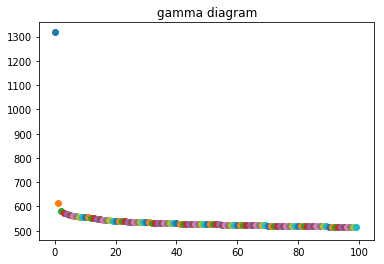

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
des_gamma = sorted(pre.gamma, reverse=True)
for index, i in enumerate(des_gamma[:100]):
    plt.scatter(index, i)
plt.title("gamma diagram")
plt.show()
plt.savefig('./data/img/gamma_diagram.png')


In [30]:
pre.calculate_cluster_center(600)

In [29]:
pre.get_cluster()

AttributeError: 'FastSearchCluster' object has no attribute 'master'

In [18]:
print(len(index_category.values()))

1219


In [24]:
import numpy as np

In [26]:
print(len(np.where(kmeans_cluster.labels_ == 0)[0]))

2212


In [30]:
## 得到聚类分组
cluster = []
for i in range(2):
    tmp = []
    for ele in np.argwhere(kmeans_cluster.labels_ == i)[:, 0]:
        tmp.append(ele)
    cluster.append(tmp)

In [33]:
## 得到每个聚类的热点标签的下标
hot_category_index = []
for clu in cluster:
    clu_array = np.zeros(len(array_user[0, :]))
    for user_index in clu:
        clu_array += array_user[user_index, :]
    des = np.argsort(-clu_array)
    hot_category_index.append(list(des[0: min(int(0.01 * len(des)), 3)]))

In [35]:
## 得到热点标签
hot_category = []
for clu in hot_category_index:
    clu_array = []
    for category_index in clu:
        clu_array.append(list(index_category.keys())[category_index])
    hot_category.append(clu_array)
